In [1]:
#import important libraries

import pandas_datareader as datareader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

In [2]:
key = 'd09c2f475463656cdf69dedb5926c06da77150cf'

In [3]:
#data collection

df = datareader.get_data_tiingo('GOOG', api_key=key)

In [4]:
df.head()

close    high     low    open   volume  \
symbol date                                                                 
GOOG   2015-09-29 00:00:00+00:00  594.97  605.00  590.22  597.28  2310284   
       2015-09-30 00:00:00+00:00  608.42  608.76  600.73  603.28  2332087   
       2015-10-01 00:00:00+00:00  611.29  612.09  599.85  608.37  1867601   
       2015-10-02 00:00:00+00:00  626.91  627.34  603.13  607.20  2684805   
       2015-10-05 00:00:00+00:00  641.47  643.01  627.00  632.00  1803643   

                                  adjClose  adjHigh  adjLow  adjOpen  \
symbol date                                                            
GOOG   2015-09-29 00:00:00+00:00    594.97   605.00  590.22   597.28   
       2015-09-30 00:00:00+00:00    608.42   608.76  600.73   603.28   
       2015-10-01 00:00:00+00:00    611.29   612.09  599.85   608.37   
       2015-10-02 00:00:00+00:00    626.91   627.34  603.13   607.20   
       2015-10-05 00:00:00+00:00    641.47   643.01  627.00   632.00   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
GOOG   2015-09-29 00:00:00+00:00    2310284      0.0          1.0  
       2015-09-30 00:00:00+00:00    2332087      0.0          1.0  
       2015-10-01 00:00:00+00:00    1867601      0.0          1.0  
       2015-10-02 00:00:00+00:00    2684805      0.0          1.0  
       2015-10-05 00:00:00+00:00    1803643      0.0          1.0

In [5]:
df.to_csv('GOOG.csv')
df = pd.read_csv('GOOG.csv')
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,GOOG,2020-09-21 00:00:00+00:00,1431.16,1448.3600,1406.55,1440.06,2888827,1431.16,1448.3600,1406.55,1440.06,2888827,0.0,1.0
1254,GOOG,2020-09-22 00:00:00+00:00,1465.46,1469.5200,1434.53,1450.09,1583201,1465.46,1469.5200,1434.53,1450.09,1583201,0.0,1.0
1255,GOOG,2020-09-23 00:00:00+00:00,1415.21,1460.9600,1407.70,1458.78,1657350,1415.21,1460.9600,1407.70,1458.78,1657350,0.0,1.0
1256,GOOG,2020-09-24 00:00:00+00:00,1428.29,1443.7088,1409.85,1411.03,1450216,1428.29,1443.7088,1409.85,1411.03,1450216,0.0,1.0
1257,GOOG,2020-09-25 00:00:00+00:00,1444.96,1450.0000,1413.34,1432.63,1323375,1444.96,1450.0000,1413.34,1432.63,1323375,0.0,1.0


In [6]:
# considering 'high' price for forecasting

high = df.reset_index()['high']

high.shape

(1258,)

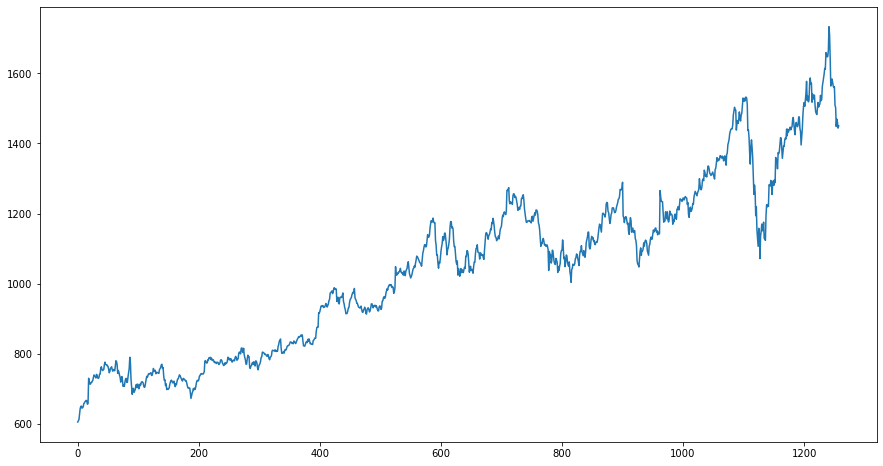

In [7]:
# plotting
plt.figure(figsize = (15, 8))
plt.plot(high)

In [8]:
# SCALING is important because LSTMs are sensitive to scale of the data
scaler = MinMaxScaler(feature_range=(0,1))
high = scaler.fit_transform(np.array(high).reshape(-1,1))

In [9]:
# splitting the data into train and test
train_size = int(len(high)*0.70)
test_size = len(high)-train_size

train, test = high[0:train_size,:], high[train_size:len(high),:1]

In [10]:
len(train), len(test)

(880, 378)

In [11]:
# configuring the dataset
def create_dataset(dataset, time_step):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        X.append(a)
        y.append(dataset[i+time_step,0])
    return np.array(X), np.array(y)

In [12]:
# considering the time_step as 150
time_step = 150
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((729, 150), (729,), (227, 150), (227,))

In [14]:
# LSTM- 3dimensional input so add 1 as the 3rd dimension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((729, 150, 1), (729,), (227, 150, 1), (227,))

In [16]:
# creating the model

model = Sequential()
model.add(LSTM(64, return_sequences = True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.4))
model.add(LSTM(63, return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(64))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150, 64)           16896     
_________________________________________________________________
dropout (Dropout)            (None, 150, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 63)           32256     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 63)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                32768     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2

In [18]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=250, batch_size=64, verbose=1)

Epoch 1/250
12/12 [==============================] - 3s 286ms/step - loss: 0.0777 - val_loss: 0.0098
Epoch 2/250
12/12 [==============================] - 3s 218ms/step - loss: 0.0117 - val_loss: 0.0094
Epoch 3/250
12/12 [==============================] - 2s 201ms/step - loss: 0.0071 - val_loss: 0.0258
Epoch 4/250
12/12 [==============================] - 2s 196ms/step - loss: 0.0048 - val_loss: 0.0122
Epoch 5/250
12/12 [==============================] - 2s 194ms/step - loss: 0.0034 - val_loss: 0.0055
Epoch 6/250
12/12 [==============================] - 2s 195ms/step - loss: 0.0030 - val_loss: 0.0064
Epoch 7/250
12/12 [==============================] - 2s 195ms/step - loss: 0.0031 - val_loss: 0.0120
Epoch 8/250
12/12 [==============================] - 2s 194ms/step - loss: 0.0033 - val_loss: 0.0080
Epoch 9/250
12/12 [==============================] - 2s 194ms/step - loss: 0.0026 - val_loss: 0.0050
Epoch 10/250
12/12 [==============================] - 2s 195ms/step - loss: 0.0029 - val_lo

12/12 [==============================] - 3s 231ms/step - loss: 8.0961e-04 - val_loss: 0.0042
Epoch 81/250
12/12 [==============================] - 3s 231ms/step - loss: 8.6585e-04 - val_loss: 0.0054
Epoch 82/250
12/12 [==============================] - 3s 231ms/step - loss: 8.3312e-04 - val_loss: 0.0051
Epoch 83/250
12/12 [==============================] - 3s 231ms/step - loss: 8.3048e-04 - val_loss: 0.0057
Epoch 84/250
12/12 [==============================] - 3s 231ms/step - loss: 8.4439e-04 - val_loss: 0.0062
Epoch 85/250
12/12 [==============================] - 3s 231ms/step - loss: 8.9976e-04 - val_loss: 0.0059
Epoch 86/250
12/12 [==============================] - 3s 231ms/step - loss: 7.8538e-04 - val_loss: 0.0063
Epoch 87/250
12/12 [==============================] - 3s 230ms/step - loss: 8.2990e-04 - val_loss: 0.0065
Epoch 88/250
12/12 [==============================] - 3s 230ms/step - loss: 8.1230e-04 - val_loss: 0.0064
Epoch 89/250
12/12 [==============================] - 3s 23

Epoch 157/250
12/12 [==============================] - 3s 244ms/step - loss: 6.9370e-04 - val_loss: 0.0031
Epoch 158/250
12/12 [==============================] - 3s 244ms/step - loss: 6.0067e-04 - val_loss: 0.0054
Epoch 159/250
12/12 [==============================] - 3s 246ms/step - loss: 5.9574e-04 - val_loss: 0.0046
Epoch 160/250
12/12 [==============================] - 3s 242ms/step - loss: 6.1830e-04 - val_loss: 0.0040
Epoch 161/250
12/12 [==============================] - 3s 243ms/step - loss: 5.5173e-04 - val_loss: 0.0046
Epoch 162/250
12/12 [==============================] - 3s 244ms/step - loss: 6.0211e-04 - val_loss: 0.0056
Epoch 163/250
12/12 [==============================] - 3s 245ms/step - loss: 6.0666e-04 - val_loss: 0.0048
Epoch 164/250
12/12 [==============================] - 3s 244ms/step - loss: 5.7190e-04 - val_loss: 0.0055
Epoch 165/250
12/12 [==============================] - 3s 245ms/step - loss: 6.3453e-04 - val_loss: 0.0024
Epoch 166/250
12/12 [================

12/12 [==============================] - 3s 255ms/step - loss: 4.5931e-04 - val_loss: 0.0020
Epoch 234/250
12/12 [==============================] - 3s 255ms/step - loss: 4.2316e-04 - val_loss: 0.0023
Epoch 235/250
12/12 [==============================] - 3s 254ms/step - loss: 4.1169e-04 - val_loss: 0.0021
Epoch 236/250
12/12 [==============================] - 3s 254ms/step - loss: 4.2617e-04 - val_loss: 0.0022
Epoch 237/250
12/12 [==============================] - 3s 254ms/step - loss: 4.4441e-04 - val_loss: 0.0016
Epoch 238/250
12/12 [==============================] - 3s 254ms/step - loss: 3.6984e-04 - val_loss: 0.0032
Epoch 239/250
12/12 [==============================] - 3s 255ms/step - loss: 4.2185e-04 - val_loss: 0.0014
Epoch 240/250
12/12 [==============================] - 3s 254ms/step - loss: 3.8218e-04 - val_loss: 0.0019
Epoch 241/250
12/12 [==============================] - 3s 253ms/step - loss: 4.3730e-04 - val_loss: 0.0033
Epoch 242/250
12/12 [==============================

In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

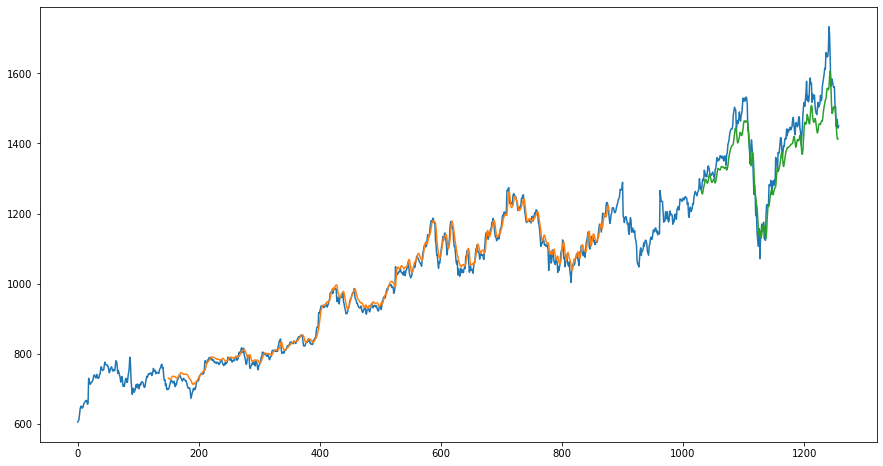

In [20]:
# Plotting 
look_back=150
trainPredictPlot = np.empty_like(high)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# 
testPredictPlot = np.empty_like(high)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(high)-1, :] = test_predict
# 
plt.figure(figsize = (15, 8))
plt.plot(scaler.inverse_transform(high))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

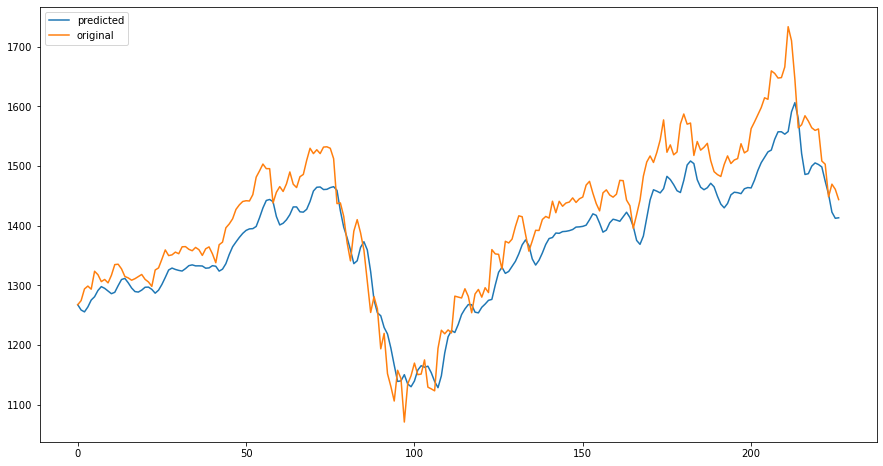

In [21]:
plt.figure(figsize = (15, 8))
plt.plot(test_predict, label='predicted')
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label='original')
plt.legend()

In [22]:
# predicgting prices for the next 90days

x_input = test[228:].reshape(1,-1)
x_input.shape
temp_input = list(x_input)
temp_input=temp_input[0].tolist()

(1, 150)

In [24]:
output = []
n_steps = 150
i = 0
while(i<90):
    if(len(temp_input)>150):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        output.extend(yhat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        output.extend(yhat.tolist())
        i = i+1

In [25]:
day_new=np.arange(1,151)
day_pred=np.arange(151,241)

len(df)

1258

### Forecast for the next 90 days

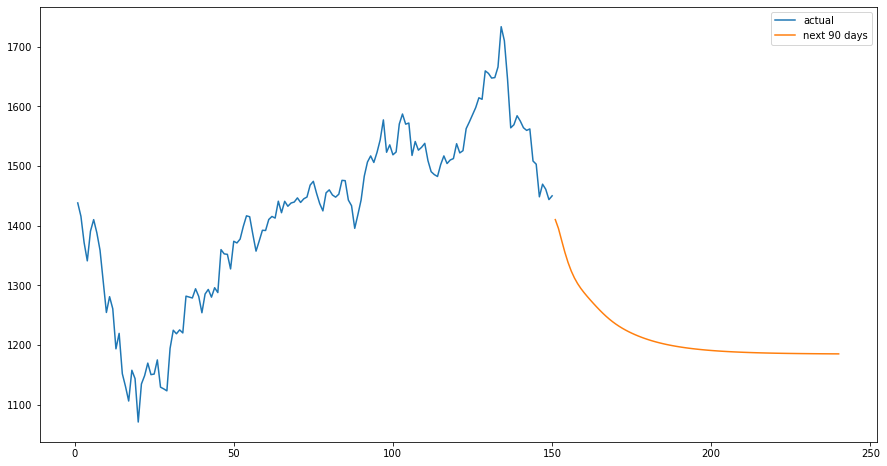

In [29]:
plt.figure(figsize = (15, 8))
plt.plot(day_new, scaler.inverse_transform(high[1108:]), label='actual')
plt.plot(day_pred, scaler.inverse_transform(output), label='next 90 days')
plt.legend()
plt.show()

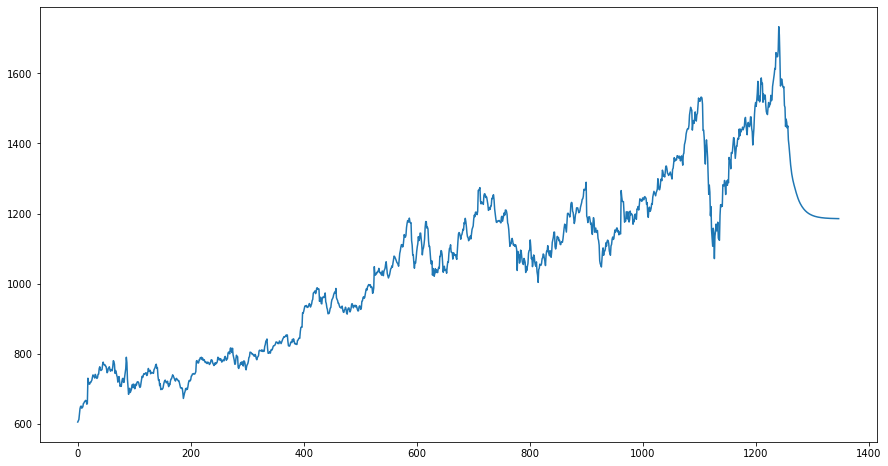

In [27]:
# visualizing the whole series along with the next 90days
df2 = high.tolist()
df2.extend(output)
df2 = scaler.inverse_transform(df2).tolist()
plt.figure(figsize = (15, 8))
plt.plot(df2)